In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/arabic-summarization-bbc-news/bbc_news_arabic_summarization.csv
/kaggle/input/arabic-summarization-bbc-news/arabic_test.jsonl


In [2]:
!python --version


Python 3.11.11


In [3]:
# CELLULE 1: Imports et vérification des fichiers
# ====================================================================================

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# ====================================================================================
# CELLULE 2: Installation des packages nécessaires
# ====================================================================================

!pip install rouge-score
!pip install pytorch-lightning

# ====================================================================================
# CELLULE 3: Imports des bibliothèques
# ====================================================================================

import pandas as pd 
import numpy as np
import re
import torch
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from transformers import MT5Tokenizer, MT5ForConditionalGeneration
from rouge_score import rouge_scorer
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import json
import matplotlib.pyplot as plt
import seaborn as sns

print("✅ Toutes les bibliothèques importées avec succès!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA disponible: {torch.cuda.is_available()}")

# ====================================================================================
# CELLULE 4: Fonctions de préprocessing améliorées
# ====================================================================================

def clean_arabic_text(text):
    """Nettoyage plus doux du texte arabe - préservation de la structure"""
    if pd.isna(text):
        return ""
    
    text = str(text)
    
    # Supprimer les URLs
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
    
    # Supprimer les caractères de contrôle
    text = re.sub(r'[\x00-\x1f\x7f-\x9f]', '', text)
    
    # Normaliser les espaces multiples
    text = re.sub(r'\s+', ' ', text)
    
    # Normalisation des lettres arabes communes (optionnel)
    text = text.replace('أ', 'ا').replace('إ', 'ا').replace('آ', 'ا')
    text = text.replace('ة', 'ه')
    
    # Supprimer les diacritiques (تشكيل) - optionnel
    arabic_diacritics = re.compile(r'[\u064B-\u0652\u0670\u0640]')
    text = arabic_diacritics.sub('', text)
    
    return text.strip()

def analyze_text_stats(df):
    """Analyser les statistiques du texte"""
    print("📊 Statistiques des textes:")
    print(f"Nombre total d'exemples: {len(df)}")
    
    df['paragraph_len'] = df['paragraph'].str.len()
    df['summary_len'] = df['summary'].str.len()
    
    print(f"Longueur moyenne des paragraphes: {df['paragraph_len'].mean():.2f}")
    print(f"Longueur moyenne des résumés: {df['summary_len'].mean():.2f}")
    print(f"Longueur max des paragraphes: {df['paragraph_len'].max()}")
    print(f"Longueur max des résumés: {df['summary_len'].max()}")
    
    return df

# ====================================================================================
# CELLULE 5: Chargement et préparation des données
# ====================================================================================

def prepare_data():
    """Charger et préparer les données d'entraînement"""
    print("🔄 Chargement des données...")
    
    # Charger les données
    data = pd.read_csv('/kaggle/input/arabic-summarization-bbc-news/bbc_news_arabic_summarization.csv')
    data = data.drop(['id', 'url', 'title'], axis=1)
    data = data.rename(columns={'text': 'paragraph', 'summary': 'summary'})
    
    print(f"Données brutes: {len(data)} exemples")
    
    # Supprimer les doublons
    data = data.drop_duplicates(subset=['paragraph'])
    data = data.drop_duplicates(subset=['summary'])
    print(f"Après suppression des doublons: {len(data)} exemples")
    
    # Nettoyer le texte
    print("🧹 Nettoyage des textes...")
    data['paragraph'] = data['paragraph'].apply(clean_arabic_text)
    data['summary'] = data['summary'].apply(clean_arabic_text)
    
    # Filtrer les données vides ou anormales
    data = data[
        (data['paragraph'].str.len() > 50) & 
        (data['summary'].str.len() > 10) &
        (data['paragraph'].str.len() < 2000) &  # Éviter les textes trop longs
        (data['summary'].str.len() < 500)
    ]
    
    print(f"Données finales après filtrage: {len(data)} exemples")
    
    # Analyser les statistiques
    data = analyze_text_stats(data)
    
    return data.reset_index(drop=True)

# Charger les données
xl_sum = prepare_data()
xl_sum.head()

/kaggle/input/arabic-summarization-bbc-news/bbc_news_arabic_summarization.csv
/kaggle/input/arabic-summarization-bbc-news/arabic_test.jsonl
  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=47acf025d95ddfc9f143475f0875ac0e055ecc53ae1c553d7d3817ff48e76d26
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge-score
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

2025-06-22 10:48:24.764883: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750589305.188087      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750589305.299928      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


✅ Toutes les bibliothèques importées avec succès!
PyTorch version: 2.6.0+cu124
CUDA disponible: True
🔄 Chargement des données...
Données brutes: 46897 exemples
Après suppression des doublons: 46690 exemples
🧹 Nettoyage des textes...
Données finales après filtrage: 25253 exemples
📊 Statistiques des textes:
Nombre total d'exemples: 25253
Longueur moyenne des paragraphes: 1272.40
Longueur moyenne des résumés: 141.84
Longueur max des paragraphes: 1999
Longueur max des résumés: 489


,summary,paragraph,paragraph_len,summary_len
0,قالت الشرطه في القطاع الهندي من اقليم كشمير ان...,وذكرت وكاله الانباء المحليه (جي.ان.اس) ان جماع...,646,163
1,"اكد مصدر في ""الحراك التهامي"" لابناء محافظه الح...",مسلح حوثي في اب وقال المصدر ان المسلحين الحوثي...,1100,324
2,افادت مصادر حركه حماس ان كتائب القسام، الجناح ...,وكانت اذاعه الجيش الاسرائيلي افادت بمقتل ثلاثه...,342,109
3,افادت مصادر مقربه من المعارضه السوريه بمقتل اك...,مسلحو المعارضه في ريف حلب وقال ياسين ابو رائد ...,425,163
4,استقال رئيس الاركان الليبي يوسف المنقوش اثر مق...,قبل المؤتمر العام الوطني الليبي الاستقاله وقبل...,600,145


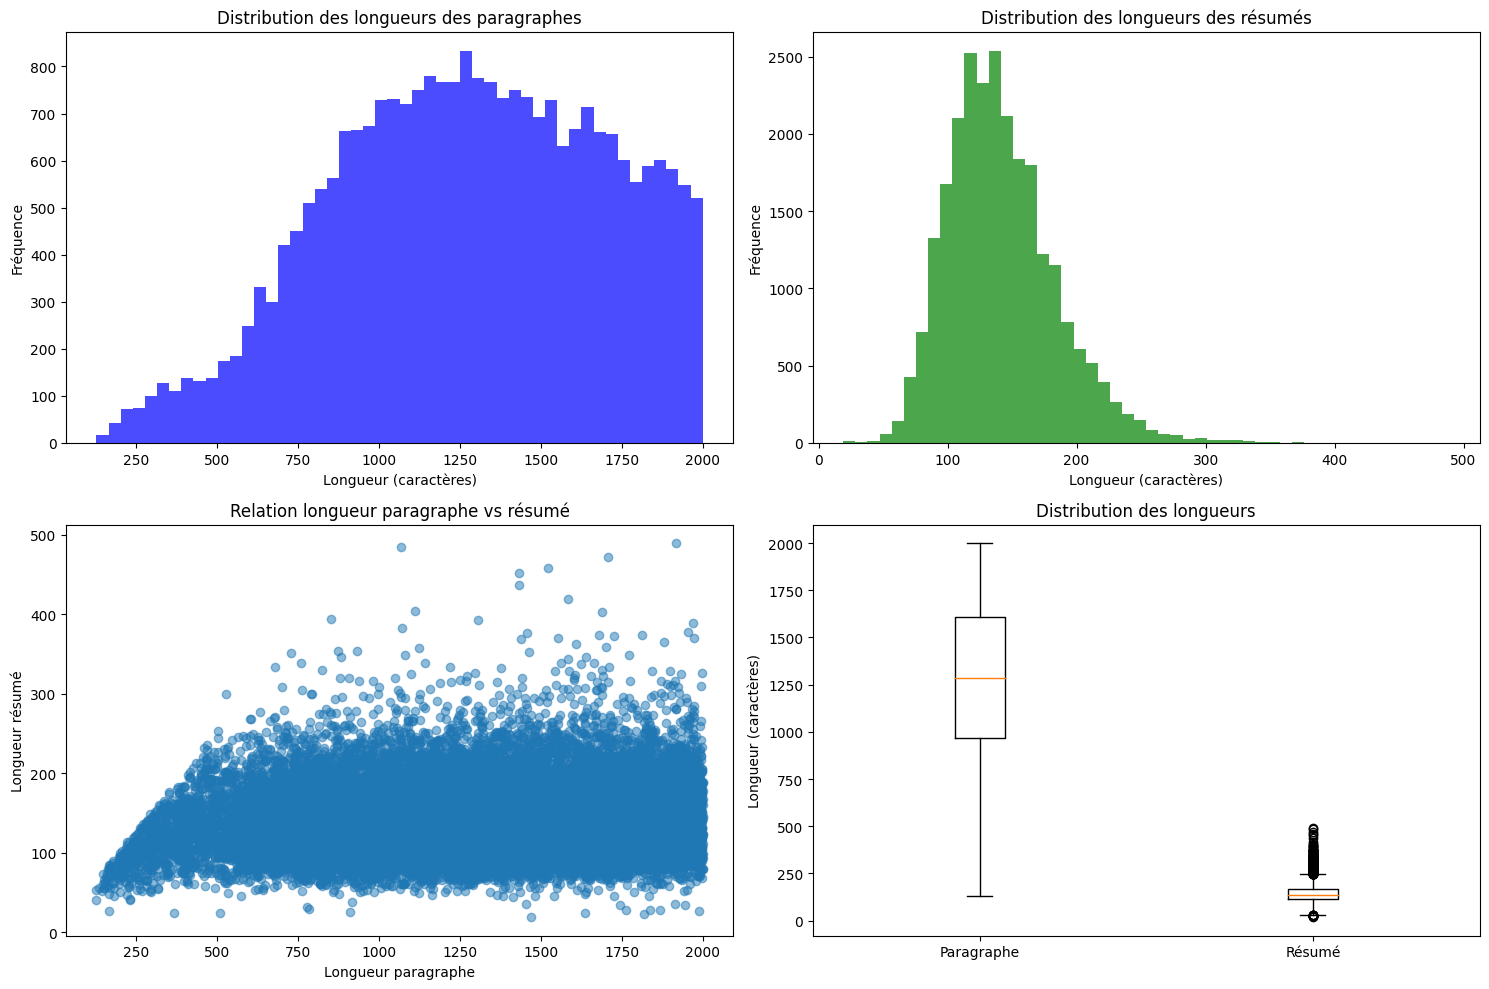


📄 Exemples de données:

--- Exemple 1 ---
Paragraphe: وذكرت وكاله الانباء المحليه (جي.ان.اس) ان جماعه "جيش محمد" المتشدده اعلنت مسؤوليتها عن الهجوم. لكن ما هي منطقه كشمير المتنازع عليها بين الهند وباكستان؟ خلال العقود الست الماضيه ظلت منطقه كشمير القريبه...
Résumé: قالت الشرطه في القطاع الهندي من اقليم كشمير ان انفجار قنبله ادى الى مقتل 40 عنصرا على الاقل من قوات الامن الخميس، بعد يوم من انفجار ادى لاصابه 12 تلميذا على الاقل.

--- Exemple 2 ---
Paragraphe: مسلح حوثي في اب وقال المصدر ان المسلحين الحوثيين هاجموا نشطاء الحراك التهامي لافشال ترتيبات كانوا يجرونها لتنظيم حشود الجمعه تحت شعار " رافضون " للتنديد باجتياح المسلحين الحوثيين للمحافظه وترتيب مسيره...
Résumé: اكد مصدر في "الحراك التهامي" لابناء محافظه الحديده لبي بي سي مقتل مسلح حوثي واصابه سته اخرين بالاضافه لجرح خمسه من مسلحي الحراك في اشتباكات اندلعت مساء امس الخميس بين الطرفين قرب ساحه اعتصام تابعه للحراك التهامي وامتدت الى عده شوارع في مدينه الحديده الواقعه على البحر الاحمر غربي اليمن والتي اجتاحها الحوثيون الاسبوع الماضي.



tokenizer_config.json:   0%|          | 0.00/82.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/553 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'T5Tokenizer'. 
The class this function is called from is 'MT5Tokenizer'.
You are using the default legacy behaviour of the <class 'transformers.models.mt5.tokenization_mt5.MT5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


✅ Tokenizer chargé. Vocab size: 250100
📊 Split des données:
   Train: 21465 exemples
   Validation: 3788 exemples
✅ DataLoaders créés avec batch_size=8
   Train batches: 2684
   Val batches: 474

🔍 Test d'un batch:
   input_ids shape: torch.Size([8, 512])
   attention_mask shape: torch.Size([8, 512])
   labels shape: torch.Size([8, 128])


In [4]:
# ====================================================================================
# CELLULE 6: Visualisation des données
# ====================================================================================

# Créer des visualisations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Distribution des longueurs des paragraphes
axes[0,0].hist(xl_sum['paragraph_len'], bins=50, alpha=0.7, color='blue')
axes[0,0].set_title('Distribution des longueurs des paragraphes')
axes[0,0].set_xlabel('Longueur (caractères)')
axes[0,0].set_ylabel('Fréquence')

# Distribution des longueurs des résumés
axes[0,1].hist(xl_sum['summary_len'], bins=50, alpha=0.7, color='green')
axes[0,1].set_title('Distribution des longueurs des résumés')
axes[0,1].set_xlabel('Longueur (caractères)')
axes[0,1].set_ylabel('Fréquence')

# Scatter plot
axes[1,0].scatter(xl_sum['paragraph_len'], xl_sum['summary_len'], alpha=0.5)
axes[1,0].set_title('Relation longueur paragraphe vs résumé')
axes[1,0].set_xlabel('Longueur paragraphe')
axes[1,0].set_ylabel('Longueur résumé')

# Box plot
data_lengths = [xl_sum['paragraph_len'], xl_sum['summary_len']]
axes[1,1].boxplot(data_lengths, labels=['Paragraphe', 'Résumé'])
axes[1,1].set_title('Distribution des longueurs')
axes[1,1].set_ylabel('Longueur (caractères)')

plt.tight_layout()
plt.show()

# Afficher quelques exemples
print("\n📄 Exemples de données:")
for i in range(3):
    print(f"\n--- Exemple {i+1} ---")
    print(f"Paragraphe: {xl_sum['paragraph'].iloc[i][:200]}...")
    print(f"Résumé: {xl_sum['summary'].iloc[i]}")

# ====================================================================================
# CELLULE 7: Classe Dataset
# ====================================================================================

class ArabicSummaryDataset(Dataset):
    def __init__(self, dataframe, tokenizer, source_max_len=512, target_max_len=128):
        self.tokenizer = tokenizer
        self.data = dataframe.reset_index(drop=True)  # ✅ Important !
        self.source_max_len = source_max_len
        self.target_max_len = target_max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        paragraph = str(self.data.iloc[index]['paragraph'])
        summary = str(self.data.iloc[index]['summary'])

        # Encodage source
        source = self.tokenizer(
            paragraph,
            max_length=self.source_max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # Encodage target  
        target = self.tokenizer(
            summary,
            max_length=self.target_max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # ✅ CORRECTION: Remplacer les tokens de padding par -100 (ignorés dans la loss)
        labels = target['input_ids'].clone()
        labels[labels == self.tokenizer.pad_token_id] = -100

        return {
            'input_ids': source['input_ids'].squeeze(),
            'attention_mask': source['attention_mask'].squeeze(),
            'labels': labels.squeeze()
        }

print("✅ Classe Dataset définie!")

# ====================================================================================
# CELLULE 8: Modèle Lightning
# ====================================================================================

class MT5Summarizer(pl.LightningModule):
    def __init__(self, model_name="google/mt5-small", lr=3e-5, warmup_steps=1000):
        super().__init__()
        self.model = MT5ForConditionalGeneration.from_pretrained(model_name)
        self.tokenizer = MT5Tokenizer.from_pretrained(model_name)
        self.lr = lr
        self.warmup_steps = warmup_steps
        # ✅ CORRECTION: use_stemmer=False pour l'arabe
        self.rouge = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=False)
        
        # Sauvegarder les hyperparamètres
        self.save_hyperparameters()
        
        # Métriques pour le suivi
        self.validation_step_outputs = []

    def forward(self, input_ids, attention_mask, labels=None):
        return self.model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

    def training_step(self, batch, batch_idx):
        output = self.forward(batch['input_ids'], batch['attention_mask'], batch['labels'])
        loss = output.loss
        self.log('train_loss', loss, prog_bar=True, on_step=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        output = self.forward(batch['input_ids'], batch['attention_mask'], batch['labels'])
        loss = output.loss

        # Génération pour évaluation ROUGE
        with torch.no_grad():
            preds = self.model.generate(
                batch['input_ids'], 
                attention_mask=batch['attention_mask'], 
                max_length=128,
                num_beams=4,
                early_stopping=True,
                no_repeat_ngram_size=2
            )
        
        pred_str = self.tokenizer.batch_decode(preds, skip_special_tokens=True)
        
        # ✅ CORRECTION: Décoder les labels correctement
        labels = batch['labels'].clone()
        labels[labels == -100] = self.tokenizer.pad_token_id
        label_str = self.tokenizer.batch_decode(labels, skip_special_tokens=True)

        # Calculer ROUGE
        rouge1_total, rouge2_total, rougel_total = 0, 0, 0
        valid_samples = 0
        
        for pred, label in zip(pred_str, label_str):
            if pred.strip() and label.strip():  # Éviter les chaînes vides
                # ✅ CORRECTION: Ordre correct pred, label
                scores = self.rouge.score(pred, label)
                rouge1_total += scores["rouge1"].fmeasure
                rouge2_total += scores["rouge2"].fmeasure
                rougel_total += scores["rougeL"].fmeasure
                valid_samples += 1

        if valid_samples > 0:
            self.log('val_loss', loss, prog_bar=True)
            self.log('rouge1', rouge1_total / valid_samples, prog_bar=True)
            self.log('rouge2', rouge2_total / valid_samples, prog_bar=True)
            self.log('rougeL', rougel_total / valid_samples, prog_bar=True)
            
            # Stocker pour affichage
            self.validation_step_outputs.append({
                'val_loss': loss,
                'rouge1': rouge1_total / valid_samples,
                'rouge2': rouge2_total / valid_samples,
                'rougeL': rougel_total / valid_samples
            })

        return loss
    
    def on_validation_epoch_end(self):
        if self.validation_step_outputs:
            avg_loss = torch.stack([x['val_loss'] for x in self.validation_step_outputs]).mean()
            avg_rouge1 = np.mean([x['rouge1'] for x in self.validation_step_outputs])
            avg_rouge2 = np.mean([x['rouge2'] for x in self.validation_step_outputs])
            avg_rougeL = np.mean([x['rougeL'] for x in self.validation_step_outputs])
            
            print(f"\n📊 Époque {self.current_epoch}:")
            print(f"   Val Loss: {avg_loss:.4f}")
            print(f"   ROUGE-1: {avg_rouge1:.4f}")
            print(f"   ROUGE-2: {avg_rouge2:.4f}")
            print(f"   ROUGE-L: {avg_rougeL:.4f}")
            
        self.validation_step_outputs.clear()

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr, weight_decay=0.01)
        
        # Learning rate scheduler avec warmup
        def lr_lambda(current_step):
            if current_step < self.warmup_steps:
                return float(current_step) / float(max(1, self.warmup_steps))
            return max(0.0, float(self.trainer.max_steps - current_step) / float(max(1, self.trainer.max_steps - self.warmup_steps)))
        
        scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
        
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "step",
                "frequency": 1,
            },
        }

print("✅ Modèle MT5Summarizer défini!")

# ====================================================================================
# CELLULE 9: Préparation des DataLoaders
# ====================================================================================

# Charger le tokenizer
tokenizer = MT5Tokenizer.from_pretrained("google/mt5-small")
print(f"✅ Tokenizer chargé. Vocab size: {tokenizer.vocab_size}")

# Split train/validation
train_df, val_df = train_test_split(xl_sum, test_size=0.15, random_state=42)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

print(f"📊 Split des données:")
print(f"   Train: {len(train_df)} exemples")
print(f"   Validation: {len(val_df)} exemples")

# Créer les datasets
train_dataset = ArabicSummaryDataset(train_df, tokenizer)
val_dataset = ArabicSummaryDataset(val_df, tokenizer)

# DataLoaders avec batch size optimisé
batch_size = 8 if torch.cuda.is_available() else 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=2)

print(f"✅ DataLoaders créés avec batch_size={batch_size}")
print(f"   Train batches: {len(train_loader)}")
print(f"   Val batches: {len(val_loader)}")

# Tester un batch
sample_batch = next(iter(train_loader))
print(f"\n🔍 Test d'un batch:")
print(f"   input_ids shape: {sample_batch['input_ids'].shape}")
print(f"   attention_mask shape: {sample_batch['attention_mask'].shape}")
print(f"   labels shape: {sample_batch['labels'].shape}")

# ====================================================================================
# CELLULE 10: Configuration de l'entraînement
# ====================================================================================

# Callbacks
checkpoint_callback = ModelCheckpoint(
    monitor='rouge1',
    dirpath='./checkpoints',
    filename='mt5-best-{epoch:02d}-{rouge1:.4f}',
    save_top_k=2,
    mode='max',  # ✅ Maximiser ROUGE-1
    save_weights_only=False,
    verbose=True
)

early_stop_callback = EarlyStopping(
    monitor='rouge1',
    patience=5,
    verbose=True,
    mode='max'
)


In [5]:
# Trainer avec configuration optimisée
trainer = pl.Trainer(
    max_epochs=10,  # ✅ Plus d'époques
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    devices=1,
    callbacks=[checkpoint_callback, early_stop_callback],
    gradient_clip_val=1.0,
    accumulate_grad_batches=2,  # ✅ Gradient accumulation
    precision=16,  # ✅ Mixed precision pour économiser la mémoire
    log_every_n_steps=50,
    val_check_interval=0.5,  # Valider 2 fois par époque
    enable_progress_bar=True
)

print("✅ Trainer configuré!")
print(f"   Device: {'GPU' if torch.cuda.is_available() else 'CPU'}")
print(f"   Max epochs: {trainer.max_epochs}")
print(f"   Gradient accumulation: {trainer.accumulate_grad_batches}")

✅ Trainer configuré!
   Device: GPU
   Max epochs: 10
   Gradient accumulation: 2


/usr/local/lib/python3.11/dist-packages/lightning_fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!


In [6]:
import pandas as pd 
import numpy as np
import re
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
from matplotlib import rc
import joblib
import json
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

import torch
from torch import nn,optim
from torch.utils.data import Dataset, DataLoader
from torchmetrics.classification import F1Score
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

from sklearn.model_selection import train_test_split

from tqdm.auto import tqdm


In [7]:
data = []
xl_sum = pd.DataFrame(data, columns=['text', 'summary'])
second = pd.read_csv('/kaggle/input/arabic-summarization-bbc-news/bbc_news_arabic_summarization.csv')
second = second.drop(['id','url','title'],axis=1)


xl_sum = pd.concat([xl_sum,second])
new_column_names = {
    'text': 'paragraph',
    'summary': 'summary',
}

# Rename the columns using the dictionary
xl_sum = xl_sum.rename(columns=new_column_names)
xl_sum.head(5)

,paragraph,summary
0,وكان الرئيس الأوكراني المؤقت، الكسندر تورتشينو...,بدأت القوات الأوكرانية الانسحاب من شبه جزيرة ا...
1,بحلول عام 2050 ستحتاج مصر إلى 21 مليار متر مكع...,"""هل سيتم تغيير العبارة الشهيرة للمؤرخ اليوناني..."
2,وذكرت وكالة الأنباء المحلية (جي.إن.إس) أن جماع...,قالت الشرطة في القطاع الهندي من إقليم كشمير إن...
3,ووقع اختياره على واد عمقه 800 متر محاط بثماني ...,في عام 816، تجول راهب يدعى كوكاي، في المنحدرات...
4,مسلح حوثي في إب وقال المصدر إن المسلحين الحوثي...,"أكد مصدر في ""الحراك التهامي"" لأبناء محافظة الح..."


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


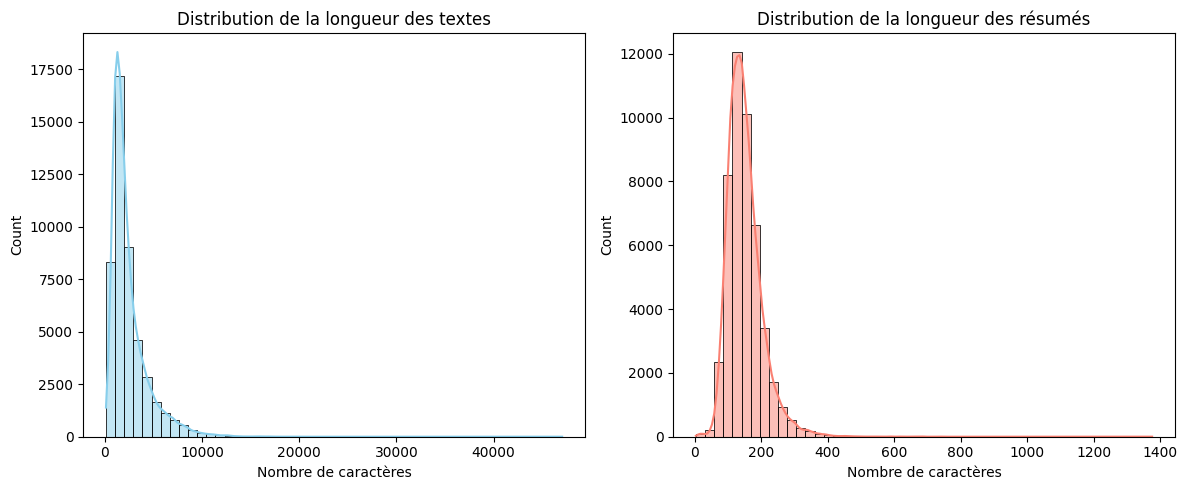

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ajout des longueurs
xl_sum['text_length'] = xl_sum['paragraph'].astype(str).apply(len)
xl_sum['summary_length'] = xl_sum['summary'].astype(str).apply(len)

# Histogramme
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.histplot(xl_sum['text_length'], bins=50, kde=True, color='skyblue')
plt.title('Distribution de la longueur des textes')
plt.xlabel('Nombre de caractères')

plt.subplot(1,2,2)
sns.histplot(xl_sum['summary_length'], bins=50, kde=True, color='salmon')
plt.title('Distribution de la longueur des résumés')
plt.xlabel('Nombre de caractères')

plt.tight_layout()
plt.show()


In [9]:
!pip install arabic-reshaper python-bidi


In [10]:
from wordcloud import WordCloud
import arabic_reshaper
from bidi.algorithm import get_display

# Joindre tout le texte
all_text = ' '.join(xl_sum['paragraph'].astype(str))
reshaped_text = arabic_reshaper.reshape(all_text)
bidi_text = get_display(reshaped_text)

# Générer le nuage
wordcloud = WordCloud(font_path='/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf',
                      background_color='white',
                      width=800, height=400).generate(bidi_text)

plt.figure(figsize=(15,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nuage de mots du texte (paragraphes)', fontsize=16)
plt.show()


In [ ]:
column_name = 'paragraph'  
xl_sum = xl_sum.drop_duplicates(subset=column_name)
column_name = 'summary'  
xl_sum = xl_sum.drop_duplicates(subset=column_name)
xl_sum.describe()

In [ ]:
counter = 0
def delete_links(input_text):
    pettern  = r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))'''
    out_text = re.sub(pettern, ' ', input_text)
    return out_text

def delete_repeated_characters(input_text):
    pattern  = r'(.)\1{2,}'
    out_text = re.sub(pattern, r"\1\1", input_text)
    return out_text

def remove_extra_spaces(input_text):
    replace = ' +'
    out_text = re.sub(replace, " ", input_text)
    words = nltk.word_tokenize(out_text)
    words = [word for word in words if word.isalpha()]
    out_text = ' '.join(words)
    return out_text

def replace_letters(input_text):
    replace = {"أ": "ا","ة": "ه","إ": "ا","آ": "ا","": ""}
    replace = dict((re.escape(k), v) for k, v in replace.items()) 
    pattern = re.compile("|".join(replace.keys()))
    out_text = pattern.sub(lambda m: replace[re.escape(m.group(0))], input_text)
    return out_text

def clean_text(input_text):
    replace = r'[^\u0621-\u064A\u0660-\u0669\u06F0-\u06F90-9]'
    out_text = re.sub(replace, " ", input_text)
    #words = nltk.word_tokenize(out_text)
    #words = [word for word in words if word.isalpha()]
    #out_text = ' '.join(words)
    return out_text

def remove_vowelization(input_text):
    vowelization = re.compile(""" ّ|َ|ً|ُ|ٌ|ِ|ٍ|ْ|ـ""", re.VERBOSE)
    out_text = re.sub(vowelization, '', input_text)
    return out_text

def delete_stopwords(input_text):
    stop_words = set(nltk.corpus.stopwords.words("arabic") + nltk.corpus.stopwords.words("english"))
    tokenizer = nltk.tokenize.WhitespaceTokenizer()
    tokens = tokenizer.tokenize(input_text)
    wnl = nltk.WordNetLemmatizer()
    lemmatizedTokens =[wnl.lemmatize(t) for t in tokens]
    out_text = [w for w in lemmatizedTokens if not w in stop_words]
    out_text = ' '.join(out_text)
    return out_text

def stem_text(input_text):
    st = ISRIStemmer()
    tokenizer = nltk.tokenize.WhitespaceTokenizer()
    tokens = tokenizer.tokenize(input_text)
    out_text = [st.stem(w) for w in tokens]
    out_text = ' '.join(out_text)
    return out_text


def text_prepare(input_text, ar_text):
    global counter
    counter +=1

    #out_text = delete_links(input_text)
    #out_text = delete_repeated_characters(out_text)
    #out_text = delete_stopwords(input_text)
    out_text = clean_text(input_text)
    #out_text = remove_extra_spaces(out_text)
    if(counter%100==0):
        print(counter,'\n',out_text)
    return out_text

In [ ]:
xl_sum['paragraph'] = xl_sum['paragraph'].apply(text_prepare, args=(True,))
xl_sum['summary'] = xl_sum['summary'].apply(text_prepare, args=(True,))

TESTER MT5 XLSUM

In [ ]:
!pip install transformers datasets evaluate


In [ ]:
!pip install rouge-score


In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import MT5Tokenizer, MT5ForConditionalGeneration
from torch.optim import AdamW
from tqdm import tqdm


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import MT5Tokenizer, MT5ForConditionalGeneration
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm  # ✅ version notebook pour barre propre
import pandas as pd
import nltk
import os

nltk.download('punkt')
nltk.download('stopwords')

# ========= Données =========
# Assure-toi que xl_sum est déjà chargé comme DataFrame avec colonnes ["paragraph", "summary"]
train_df, val_df = train_test_split(xl_sum, test_size=0.1, random_state=42)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

# ========= Tokenizer =========
model_name = "csebuetnlp/mT5_multilingual_XLSum"
tokenizer = MT5Tokenizer.from_pretrained(model_name)

max_input_length = 256
max_target_length = 64

class SummarizationDataset(Dataset):
    def __init__(self, source_text, target_text, tokenizer):
        self.source_text = source_text
        self.target_text = target_text
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.source_text)

    def __getitem__(self, index):
        input_text = str(self.source_text[index])
        target_text = str(self.target_text[index])

        input_encoding = self.tokenizer(
            input_text,
            max_length=max_input_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        target_encoding = self.tokenizer(
            target_text,
            max_length=max_target_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        labels = target_encoding["input_ids"]
        labels[labels == tokenizer.pad_token_id] = -100

        return {
            "input_ids": input_encoding["input_ids"].squeeze(),
            "attention_mask": input_encoding["attention_mask"].squeeze(),
            "labels": labels.squeeze()
        }

# ========= Datasets & DataLoaders =========
train_dataset = SummarizationDataset(train_df["paragraph"], train_df["summary"], tokenizer)
val_dataset = SummarizationDataset(val_df["paragraph"], val_df["summary"], tokenizer)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2)

# ========= Modèle =========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MT5ForConditionalGeneration.from_pretrained(model_name).to(device)
optimizer = AdamW(model.parameters(), lr=5e-5)

# ========= Entraînement =========
epochs = 3
output_dir = "/kaggle/working/mt5_finetuned"  # modifie selon ton environnement

os.makedirs(output_dir, exist_ok=True)

for epoch in range(epochs):
    print(f"\n===== Epoch {epoch+1}/{epochs} =====")
    model.train()
    total_loss = 0

    loop = tqdm(train_loader, leave=True, ncols=100)  # ✅ barre de progression horizontale propre

    for batch in loop:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        torch.cuda.empty_cache()

        total_loss += loss.item()
        loop.set_description(f"Epoch {epoch+1}")
        loop.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(train_loader)
    print(f"✅ Moyenne de la perte à l'époque {epoch+1} : {avg_loss:.4f}")

    # ✅ Sauvegarde du modèle après chaque epoch
    epoch_dir = os.path.join(output_dir, f"epoch_{epoch+1}")
    os.makedirs(epoch_dir, exist_ok=True)
    model.save_pretrained(epoch_dir)
    tokenizer.save_pretrained(epoch_dir)
    print(f"💾 Modèle sauvegardé dans : {epoch_dir}")


In [ ]:
model.save_pretrained("/kaggle/working/mt5_arabic_xlsum_finetuned")
tokenizer.save_pretrained("/kaggle/working/mt5_arabic_xlsum_finetuned")


In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch

model_path = "/kaggle/working/mt5_arabic_xlsum_finetuned"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSeq2SeqLM.from_pretrained(model_path)
model.to(device)
model.eval()


In [ ]:
import json

test_texts = []
test_summaries = []

with open('/kaggle/input/arabic-summarization-bbc-news/arabic_test.jsonl', 'r', encoding='utf-8') as f:
    for line in f:
        data = json.loads(line)
        test_texts.append(data['text'])
        test_summaries.append(data['summary'])


In [ ]:
def generate_summary(text, max_length=150, num_beams=4):
    inputs = tokenizer.encode(text, return_tensors='pt', truncation=True, max_length=512).to(device)
    summary_ids = model.generate(inputs, max_length=max_length, num_beams=num_beams, early_stopping=True)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary


In [ ]:
pred_summaries = []
for txt in test_texts:
    pred = generate_summary(txt)
    pred_summaries.append(pred)


In [ ]:
from rouge_score import rouge_scorer
import bert_score

# ROUGE
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
rouge1_list, rouge2_list, rougeL_list = [], [], []

for ref, pred in zip(test_summaries, pred_summaries):
    scores = scorer.score(ref, pred)
    rouge1_list.append(scores['rouge1'].fmeasure)
    rouge2_list.append(scores['rouge2'].fmeasure)
    rougeL_list.append(scores['rougeL'].fmeasure)

print(f"ROUGE-1 F1: {sum(rouge1_list)/len(rouge1_list):.4f}")
print(f"ROUGE-2 F1: {sum(rouge2_list)/len(rouge2_list):.4f}")
print(f"ROUGE-L F1: {sum(rougeL_list)/len(rougeL_list):.4f}")

# BERTScore
P, R, F1 = bert_score.score(pred_summaries, test_summaries, lang='ar', rescale_with_baseline=True)
print(f"BERTScore Precision: {P.mean().item():.4f}")
print(f"BERTScore Recall: {R.mean().item():.4f}")
print(f"BERTScore F1: {F1.mean().item():.4f}")


In [ ]:
from transformers import MT5Tokenizer, MT5ForConditionalGeneration
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from rouge_score import rouge_scorer


In [ ]:
for i in range(3):
    print("Input:", xl_sum['paragraph'].iloc[i])
    print("Target:", xl_sum['summary'].iloc[i])


In [ ]:
class ArabicSummaryDataset(Dataset):
    def __init__(self, dataframe, tokenizer, source_max_len=512, target_max_len=128):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.source_max_len = source_max_len
        self.target_max_len = target_max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        paragraph = str(self.data.loc[index, 'paragraph'])
        summary = str(self.data.loc[index, 'summary'])

        source = self.tokenizer.batch_encode_plus(
            [paragraph],
            max_length=self.source_max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        target = self.tokenizer.batch_encode_plus(
            [summary],
            max_length=self.target_max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': source['input_ids'].squeeze(),
            'attention_mask': source['attention_mask'].squeeze(),
            'labels': target['input_ids'].squeeze()
        }


In [ ]:
class MT5Summarizer(pl.LightningModule):
    def __init__(self, model_name="google/mt5-small", lr=3e-5):
        super().__init__()
        self.model = MT5ForConditionalGeneration.from_pretrained(model_name)
        self.tokenizer = MT5Tokenizer.from_pretrained(model_name)
        self.lr = lr
        self.rouge = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    def forward(self, input_ids, attention_mask, labels=None):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        return output

    def training_step(self, batch, batch_idx):
        output = self.forward(batch['input_ids'], batch['attention_mask'], batch['labels'])
        loss = output.loss
        self.log('train_loss', loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        output = self.forward(batch['input_ids'], batch['attention_mask'], batch['labels'])
        loss = output.loss

        preds = self.model.generate(batch['input_ids'], attention_mask=batch['attention_mask'], max_length=128)
        pred_str = self.tokenizer.batch_decode(preds, skip_special_tokens=True)
        label_str = self.tokenizer.batch_decode(batch['labels'], skip_special_tokens=True)

        rouge1, rouge2, rougel = 0, 0, 0
        for p, l in zip(pred_str, label_str):
            scores = self.rouge.score(p, l)
            rouge1 += scores["rouge1"].fmeasure
            rouge2 += scores["rouge2"].fmeasure
            rougel += scores["rougeL"].fmeasure

        n = len(pred_str)
        self.log('val_loss', loss, prog_bar=True)
        self.log('rouge1', rouge1 / n, prog_bar=True)
        self.log('rouge2', rouge2 / n, prog_bar=True)
        self.log('rougeL', rougel / n, prog_bar=True)

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=self.lr)


In [ ]:
from transformers import MT5Tokenizer
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

# Charger le tokenizer mT5
tokenizer = MT5Tokenizer.from_pretrained("google/mt5-small")

# Split train / validation
train_df, val_df = train_test_split(xl_sum, test_size=0.1, random_state=42)

# Très important : réinitialiser l'index
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

# Création des datasets (tu dois avoir déjà défini la classe ArabicSummaryDataset)
train_dataset = ArabicSummaryDataset(train_df, tokenizer)
val_dataset = ArabicSummaryDataset(val_df, tokenizer)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4)


In [ ]:
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping


checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='./checkpoints',           # Folder where to save
    filename='mt5-best-checkpoint',    # Final file name
    save_top_k=1,                      # ✅ Only one best checkpoint
    mode='min'                         # Choose lowest val_loss
)


early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=3,
    verbose=True,
    mode='min'
)

trainer = pl.Trainer(
    max_epochs=5,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    devices=1,
    callbacks=[checkpoint_callback, early_stop_callback],
    gradient_clip_val=1.0,
)




model = MT5Summarizer()
trainer.fit(model, train_loader, val_loader)


In [ ]:
model.model.save_pretrained("mt5_arabic_summary_model")
tokenizer.save_pretrained("mt5_arabic_summary_model")


In [ ]:
import pandas as pd

test_df = pd.read_json("/kaggle/input/arabic-summarization-bbc-news/arabic_test.jsonl", lines=True)
test_df.head()


In [ ]:
import json
import pandas as pd
from transformers import MT5ForConditionalGeneration, MT5Tokenizer
from rouge_score import rouge_scorer
from tqdm import tqdm
import torch

# Charger modèle et tokenizer
model = MT5ForConditionalGeneration.from_pretrained("mt5_arabic_summary_model").to("cuda")
tokenizer = MT5Tokenizer.from_pretrained("mt5_arabic_summary_model")
model.eval()


In [ ]:
# Charger fichier JSONL
test_file = '/kaggle/input/arabic-summarization-bbc-news/arabic_test.jsonl'
data = []

with open(test_file, 'r', encoding='utf-8') as f:
    for line in f:
        data.append(json.loads(line))

# Charger dans un DataFrame
df = pd.DataFrame(data)

# Garder 60% aléatoirement
df_sample = df.sample(frac=0.6, random_state=42).reset_index(drop=True)


In [ ]:
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

total_rouge1 = 0
total_rouge2 = 0
total_rougeL = 0

for i, row in tqdm(df_sample.iterrows(), total=len(df_sample)):
    input_text = row['text']
    reference = row['summary']

    # Encode input
    inputs = tokenizer.encode(input_text, return_tensors='pt', max_length=512, truncation=True).to("cuda")

    # Generate summary
    output = model.generate(inputs, max_length=128, num_beams=4, early_stopping=True)
    prediction = tokenizer.decode(output[0], skip_special_tokens=True)

    # Calculate ROUGE
    scores = scorer.score(reference, prediction)
    total_rouge1 += scores['rouge1'].fmeasure
    total_rouge2 += scores['rouge2'].fmeasure
    total_rougeL += scores['rougeL'].fmeasure

# Moyenne
n = len(df_sample)
print(f"✔️ Résultats sur 60% des données de test ({n} exemples) :")
print(f"ROUGE-1: {total_rouge1 / n:.4f}")
print(f"ROUGE-2: {total_rouge2 / n:.4f}")
print(f"ROUGE-L: {total_rougeL / n:.4f}")


In [ ]:
import json
import pandas as pd
import torch
from tqdm import tqdm
from transformers import MT5ForConditionalGeneration, MT5Tokenizer
from rouge_score import rouge_scorer

# =======================
# 📦 Chargement du modèle
# =======================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = "mt5_arabic_summary_model"

model = MT5ForConditionalGeneration.from_pretrained(model_path).to(device)
tokenizer = MT5Tokenizer.from_pretrained(model_path)
model.eval()

print("✅ Modèle et tokenizer chargés")

# =======================
# 📄 Chargement des données
# =======================
test_path = "/kaggle/input/arabic-summarization-bbc-news/arabic_test.jsonl"

with open(test_path, 'r', encoding='utf-8') as f:
    data = [json.loads(line) for line in f]

df = pd.DataFrame(data)

# ✂️ Garder un échantillon de 60%
df_sample = df.sample(frac=0.2, random_state=42).reset_index(drop=True)
print(f"📊 Nombre d'exemples sélectionnés : {len(df_sample)}")

# =======================
# 🧠 Évaluation ROUGE
# =======================
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=False)  # 🔁 Pas de stemmer pour l'arabe

total_rouge1, total_rouge2, total_rougeL = 0.0, 0.0, 0.0
results = []

print("🚀 Début de l'évaluation...")
for _, row in tqdm(df_sample.iterrows(), total=len(df_sample)):
    input_text = row['text']
    reference = row['summary']

    # Tokenisation + génération
    inputs = tokenizer.encode(input_text, return_tensors='pt', max_length=512, truncation=True).to(device)

    with torch.no_grad():
        output_ids = model.generate(
            inputs,
            max_length=128,
            num_beams=4,
            early_stopping=True,
            no_repeat_ngram_size=3
        )

    prediction = tokenizer.decode(output_ids[0], skip_special_tokens=True)

    # ROUGE score
    scores = scorer.score(reference, prediction)
    total_rouge1 += scores['rouge1'].fmeasure
    total_rouge2 += scores['rouge2'].fmeasure
    total_rougeL += scores['rougeL'].fmeasure

    # Stocker les résultats pour inspection manuelle
    results.append({
        "Text": input_text,
        "Reference": reference,
        "Prediction": prediction,
        "ROUGE-1": round(scores['rouge1'].fmeasure, 4),
        "ROUGE-2": round(scores['rouge2'].fmeasure, 4),
        "ROUGE-L": round(scores['rougeL'].fmeasure, 4),
    })

# =======================
# ✅ Résultats finaux
# =======================
n = len(df_sample)
avg_r1 = total_rouge1 / n
avg_r2 = total_rouge2 / n
avg_rL = total_rougeL / n

print(f"\n✔️ Évaluation sur {n} exemples :")
print(f"ROUGE-1: {avg_r1:.4f}")
print(f"ROUGE-2: {avg_r2:.4f}")
print(f"ROUGE-L: {avg_rL:.4f}")

# =======================
# 💾 Sauvegarde facultative
# =======================
results_df = pd.DataFrame(results)
results_df.to_csv("evaluation_results.csv", index=False)
print("💾 Résultats détaillés sauvegardés dans 'evaluation_results.csv'")


In [ ]:
# Afficher quelques exemples
for i in range(5):
    print("Texte:", df_sample['text'][i][:300], '...')
    print("Résumé attendu:", df_sample['summary'][i])
    
    inputs = tokenizer.encode(df_sample['text'][i], return_tensors='pt', truncation=True, max_length=512).to("cuda")
    output = model.generate(inputs, max_length=128, num_beams=4)
    generated = tokenizer.decode(output[0], skip_special_tokens=True)
    
    print("Résumé généré:", generated)
    print("-" * 80)


OOF SH**

In [ ]:
!pip install -q rouge-score


!pip install -q transformers datasets rouge-score sentence-transformers
MT5 ANOTHER TRY 

In [ ]:
!pip install -q transformers datasets rouge-score sentence-transformers


In [ ]:
import pandas as pd
from datasets import Dataset
from transformers import (
    MT5ForConditionalGeneration,
    MT5Tokenizer,
    DataCollatorForSeq2Seq,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer
)
import nltk
nltk.download('punkt')

from sklearn.model_selection import train_test_split
import torch


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)


In [ ]:
# Tu as déjà nettoyé les données
xl_sum = xl_sum.sample(frac=0.5, random_state=42).reset_index(drop=True)


In [ ]:
model_name = "google/mt5-base"  # Ou "google/mt5-large"
tokenizer = MT5Tokenizer.from_pretrained(model_name)


In [ ]:
def preprocess_function(examples):
    inputs = ["تلخيص: " + ex for ex in examples["paragraph"]]  # Ajoute le prefix "summarize:"
    targets = examples["summary"]
    
    model_inputs = tokenizer(inputs, max_length=512, truncation=True, padding="max_length")

    labels = tokenizer(targets, max_length=128, truncation=True, padding="max_length")
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs


In [ ]:
dataset = Dataset.from_pandas(xl_sum[['paragraph', 'summary']])
dataset = dataset.map(preprocess_function, batched=True)


In [ ]:
train_test = dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = train_test['train']
eval_dataset = train_test['test']


In [ ]:
model = MT5ForConditionalGeneration.from_pretrained(model_name).to(device)


In [ ]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)


In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    eval_strategy="no",
    logging_strategy="steps",
    logging_steps=200,
    save_strategy="no",
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    num_train_epochs=3,
    predict_with_generate=True,
    fp16=True,
    logging_dir="./logs",
    logging_first_step=True,
    report_to="none",
)


In [ ]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator
)


In [ ]:
trainer.train()
